In [1]:
import operator
import random
import requests
import time
import pandas as pd
import networkx as nx
import seaborn as sns
import numpy as np
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data

### Movies data

In [2]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv('movie.metadata.tsv', sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_runtime'])
df_movies.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}


### Characters data

In [3]:
a_cols = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_actors=pd.read_csv('character.metadata.tsv', sep='\t', names=a_cols, parse_dates=['movie_release_date'])
df_actors['movie_release_date']=pd.to_datetime(df_actors['movie_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime

#Change problematic dates
df_actors['actor_dob'] = df_actors['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_actors['actor_dob'] = pd.to_datetime(df_actors['actor_dob'], errors = 'coerce')
df_actors.dropna(subset='actor_name', inplace=True)
df_actors.drop_duplicates(keep='first', inplace=True)
df_actors.drop_duplicates(subset=["wikipedia_movie_id", "character_name", "actor_name", "movie_release_date"], keep=False, inplace=True)
df_actors = df_actors[df_actors['actor_age'] > 0]

df_actors.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# Movie general analysis

### Freebase movie ID

In [4]:
def check_freebase_id(x):
    id_m = x.split('/')[1]
    return id_m=='m'

In [5]:
df_movies['freebase_m_ID'].apply(lambda x: check_freebase_id(x)).value_counts()

True    81113
Name: freebase_m_ID, dtype: int64

All freebase movie ID start with '/m/'. So they are all movie wikipedia ID.

In [7]:
tot = []
k_size = 5
for k in range(k_size):
    n = 100
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url='%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(sum(tot)/k_size))

There is around 75.60% of the movies that have an active wikipedia freebase ID.


### Movie name

In [8]:
nb_movies = df_movies[["m_name", "freebase_m_ID"]].value_counts().count()
unique_wikipedia_m_id = df_movies["wikipedia_m_ID"].count()
print("There are {} different movies, corresponding to {} different wikipedia ID.".format(nb_movies, 
                                                                                          unique_wikipedia_m_id))

There are 81113 different movies, corresponding to 81113 different wikipedia ID.


In [9]:
nb_duplicated_titles = df_movies[df_movies.duplicated('m_name', keep=False)]['wikipedia_m_ID'].count()
print("There are {} movies with duplicated titles.".format(nb_duplicated_titles))

There are 9706 movies with duplicated titles.


In [10]:
df_movies["m_name"].value_counts()

Alice in Wonderland               15
Les Misérables                    11
The Three Musketeers              11
A Christmas Carol                 11
Macbeth                           10
                                  ..
His Wife's Child                   1
Emmanuelle 3: A Lesson in Love     1
Suffering Man's Charity            1
Maa Tujhhe Salaam                  1
Spliced                            1
Name: m_name, Length: 75478, dtype: int64

One can see that when some movies have the same title, it mainly corresponds to either remake movies or common titles where movies have nothing in common.

### Movie release date

In [11]:
nb_movies_with_release_date = df_movies['m_release_date'].dropna().count()
print("There are {} movies with a known release date. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_release_date, nb_movies_with_release_date / nb_movies * 100))

There are 73965 movies with a known release date. It corresponds to 91.19 % of the movies.


Histogram of release date

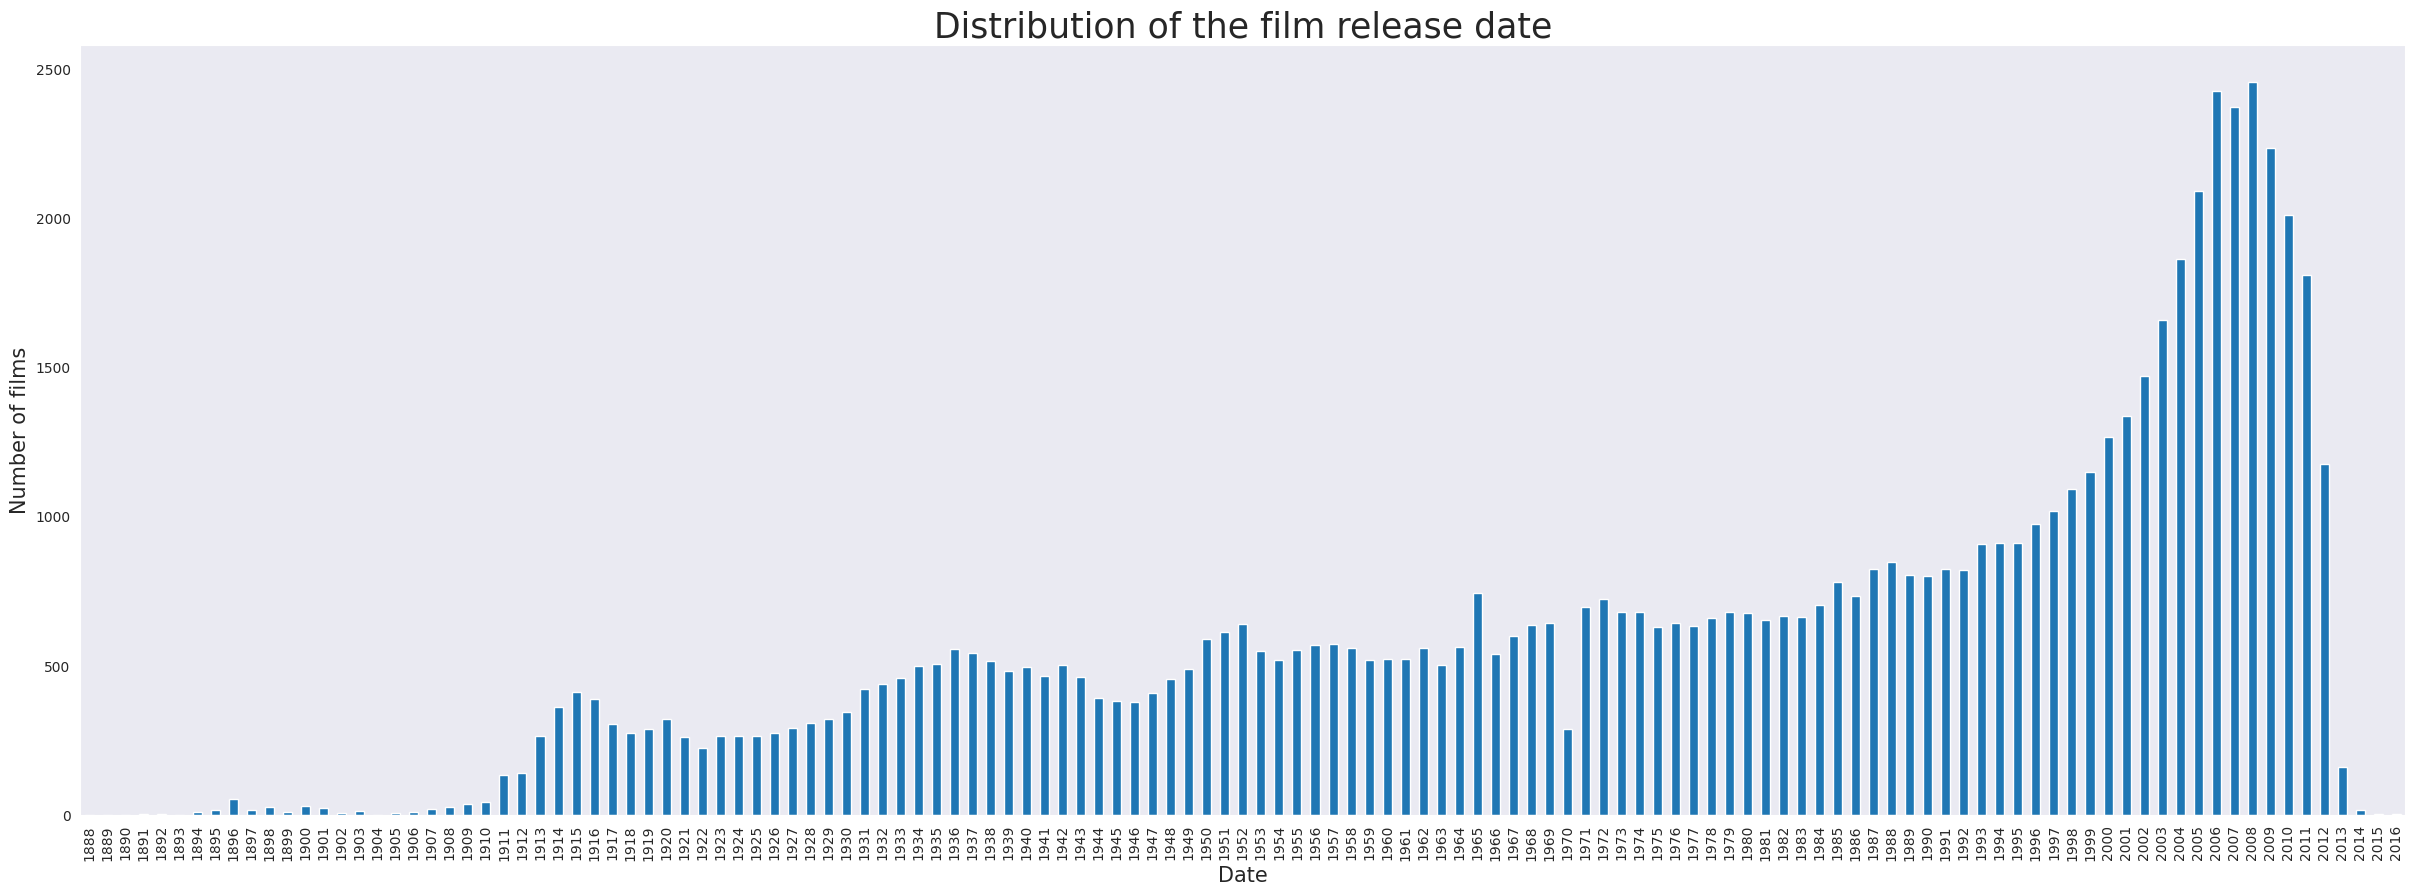

The dataset is composed of 


In [12]:
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()
print("The dataset is composed of ")

In [13]:
feature_wiki_ID={
    "runtime": 'AP2047',
    "pubdate":'AP577'
}

def get_freebase_feature(row, value, op, n_lim, feature):
    ops = {
    '>=' : operator.ge,
    '<=' : operator.le,
    '>' : operator.gt,
    '<' : operator.lt,
    }
    op = ops[op]
    val_to_compare = value
    if feature == 'pubdate':
        val_to_compare=value.year
    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(feature, id_m, feature_wiki_ID[feature], feature)
        response = requests.get(query)
        response_json = response.json()
        if len(response_json['results']['bindings']):
            if feature == 'runtime':
                new_value = float(response_json['results']['bindings'][0][feature]['value'])
                if new_value!=value:
                    time.sleep(5)
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}min.".format(row['m_name'], feature,
                                                                                               value, feature, 
                                                                                               new_value))
                    value = new_value
            elif feature=='pubdate':
                new_value = (response_json['results']['bindings'][0][feature]['value'])
                new_value=new_value.replace("Z", "")
                new_value = datetime.strptime(new_value,'%Y-%m-%dT%H:%M:%S')
                if new_value.year!=value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature, 
                                                                                               new_value.date()))
                    value = new_value
            
    return value

In [14]:
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

Avatar 2 movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2022-12-14.
Total Dhamaal movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2018-12-07.
Battle Angel movie had a pubdate of 2016-01-01. However, using freebase ID, pubdate=2019-02-06.


As the dataset is not representative after 2015, the analysis will only be done with movies released before 2015.


In [15]:
df_movies = df_movies[df_movies['m_release_date'].dt.year < 2015]

### Movie box office

In [16]:
nb_movies_with_BO = df_movies['m_BO_revenue'].dropna().count()
print("There are {} movies with a known box office revenue. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_BO, nb_movies_with_BO / nb_movies * 100))

There are 8296 movies with a known box office revenue. It corresponds to 10.23 % of the movies.


Histogram of box office

/tmp/ipykernel_156640/992499106.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_movies.groupby(df_movies.m_release_date.dt.year).mean()['m_BO_revenue'].dropna().plot(figsize=(20,6))


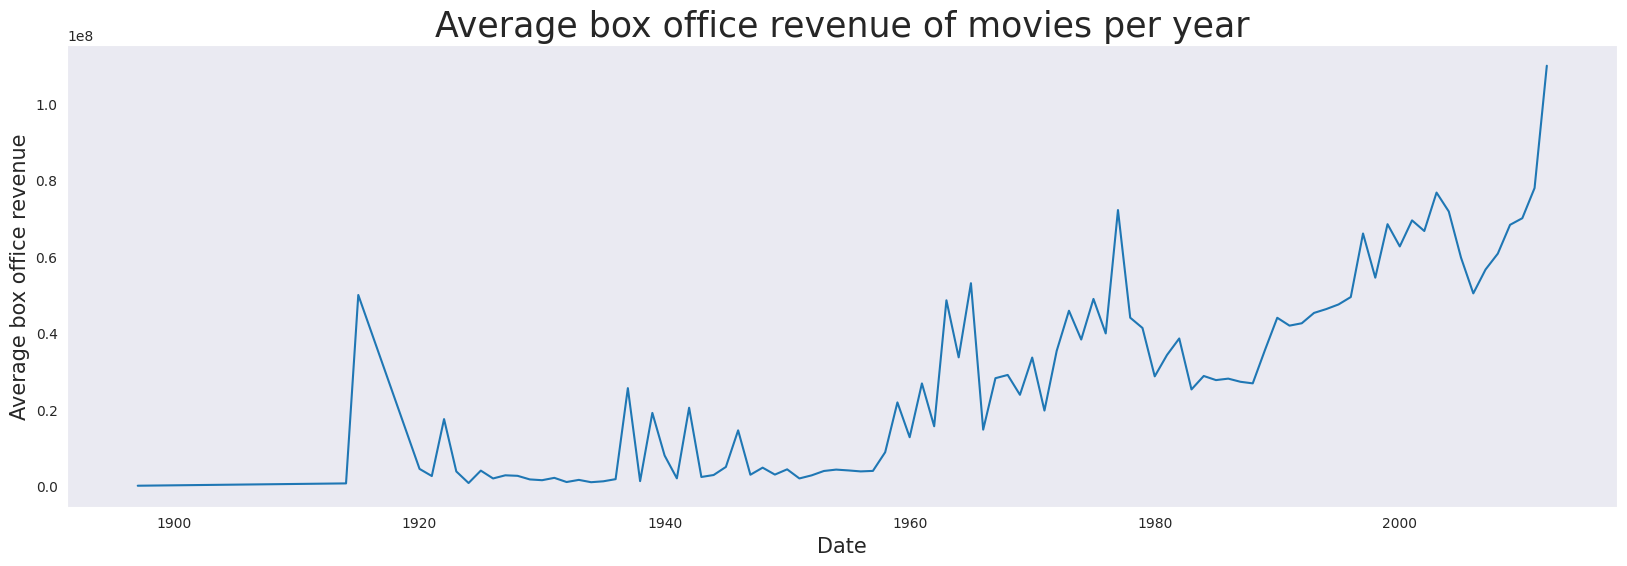

In [17]:
df_movies.groupby(df_movies.m_release_date.dt.year).mean()['m_BO_revenue'].dropna().plot(figsize=(20,6))
plt.grid()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average box office revenue', fontsize=15)
plt.title('Average box office revenue of movies per year', fontsize=25)
plt.show()

### Movie runtime

In [18]:
nb_movies_with_runtime = df_movies['m_runtime'].dropna().count()
print("There are {} movies with a known runtime duration. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_runtime, nb_movies_with_runtime / nb_movies * 100))

There are 58267 movies with a known runtime duration. It corresponds to 71.83 % of the movies.


Histogram of the runtime

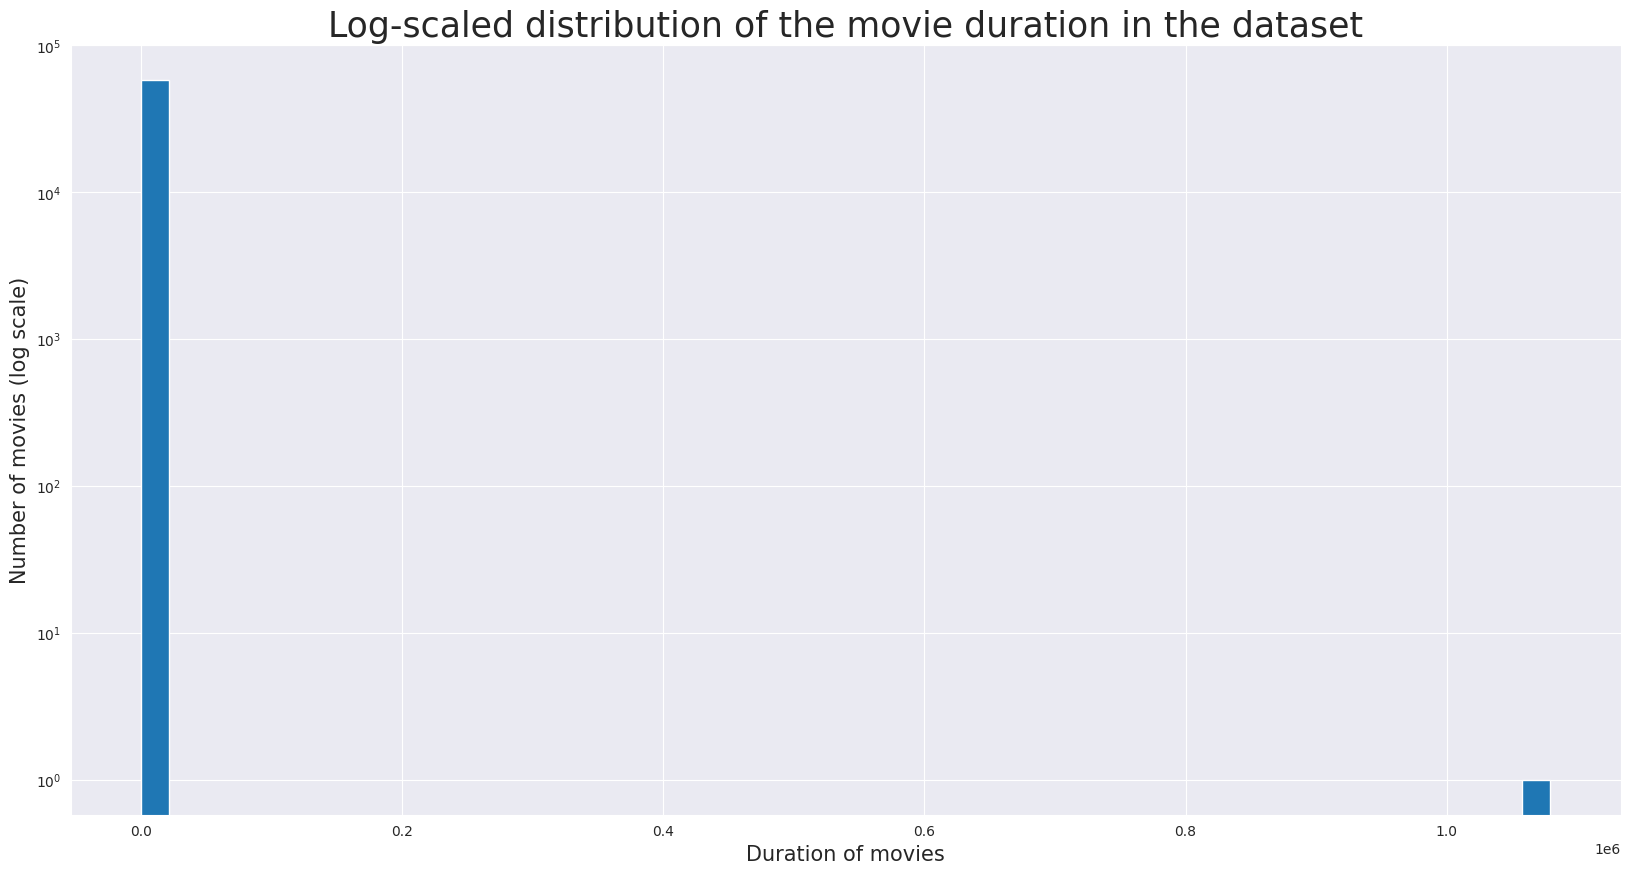

In [19]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [20]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime']>= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime']<= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1.".format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 12 movies which a runtime > 1500 and 87 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

In [21]:
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.0. However, using freebase ID, runtime=88.0min.
Dhool Ka Phool movie had a runtime of 1533.0. However, using freebase ID, runtime=153.0min.
Cinématon movie had a runtime of 9360.0. However, using freebase ID, runtime=11828.0min.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.0. However, using freebase ID, runtime=148.0min.
As Seen Through a Telescope movie had a runtime of 0.7. However, using freebase ID, runtime=55.0min.
Men Boxing movie had a runtime of 0.0833333333333. However, using freebase ID, runtime=5.0min.
Fred Ott's Sneeze movie had a runtime of 0.0833333333333. However, using freebase ID, runtime=4.0min.
Sick Kitten movie had a runtime of 0.566666666667. However, using freebase ID, runtime=34.0min.
The X-Rays movie had a runtime of 0.733333333333. However, using freebase ID, runtime=44.0min.
Blacksmith Scene movie had a runtime of 0.566666666667. However, using freebase ID, runtime=34.0min.
L'Arroseur Arrosé movie had a runtim

The new distribution of runtimes among movies can now be computed.

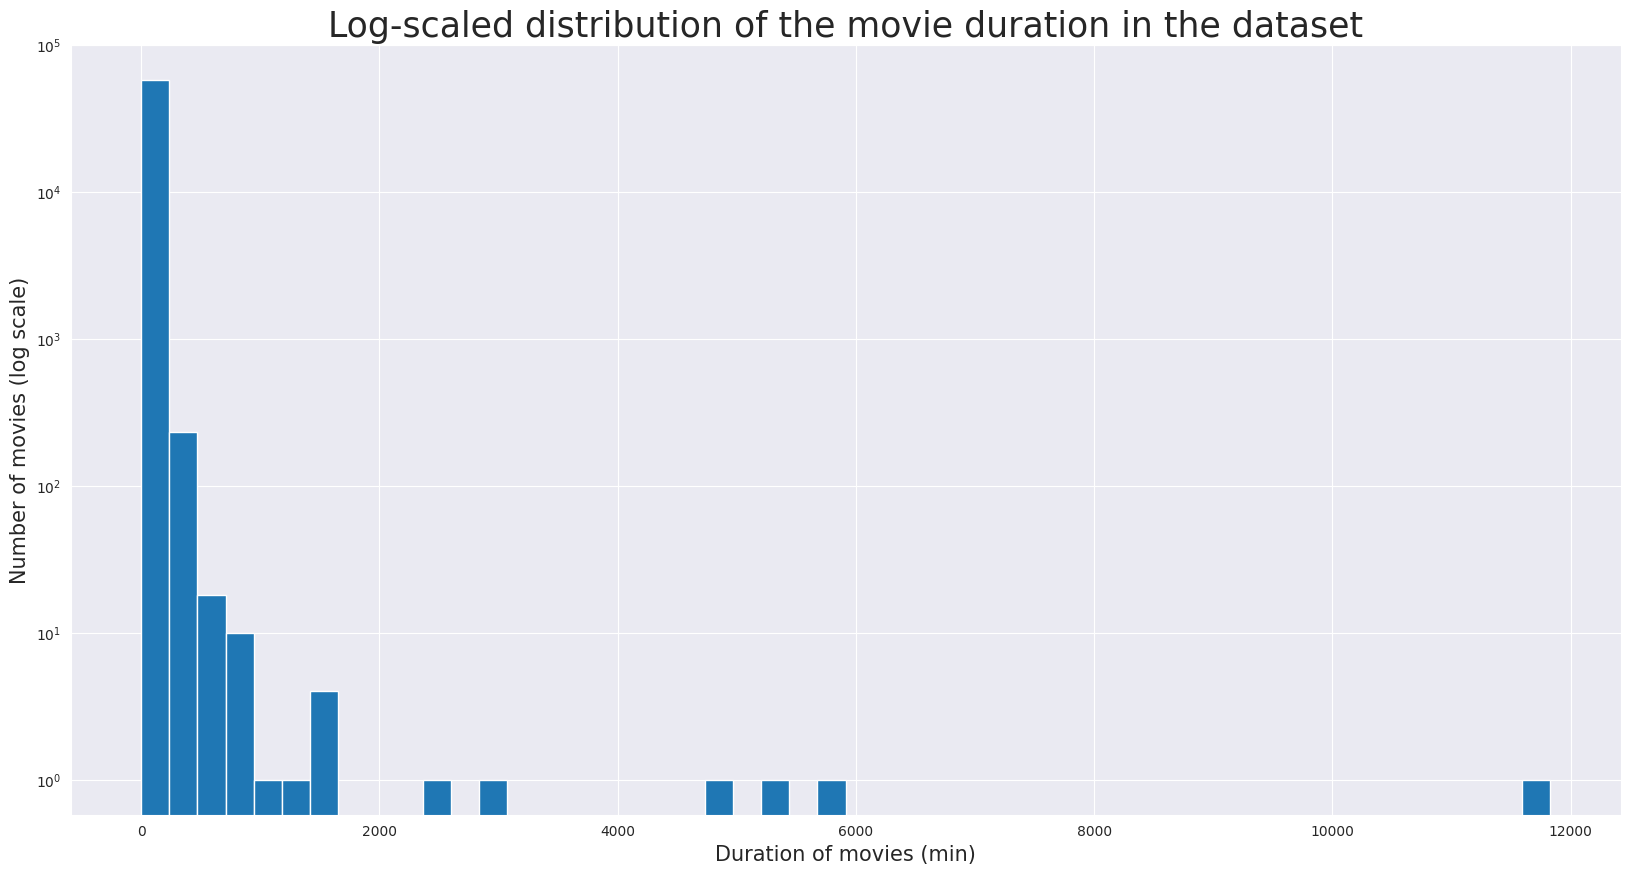

In [22]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies (min)', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

The average duration of a movie throughout the years is now studied. A bootstrap version is computed. 

In [23]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

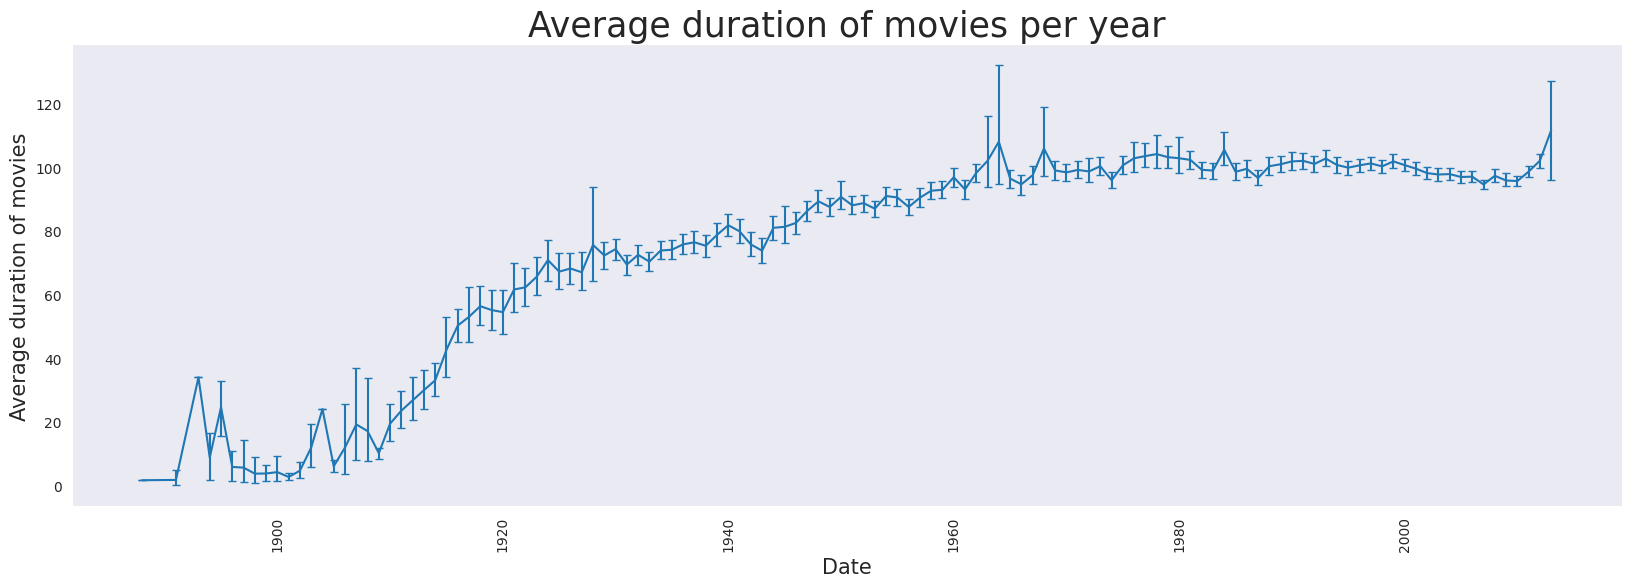

In [24]:
merge = df_movies.m_release_date.dt.year

stat = df_movies[df_movies['m_runtime']<5000][['m_release_date', 'm_runtime']].dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_runtime': x['m_runtime'].mean(),
    'lower_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[0],
    'upper_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[1]
}))

plt.figure(figsize=(20,6))
plt.errorbar(stat.index, stat.average_runtime,
         yerr = [-stat.lower_err_runtime + stat.average_runtime, 
                -stat.average_runtime + stat.upper_err_runtime],
         capsize= 3)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Average duration of movies', fontsize=15)
plt.title('Average duration of movies per year', fontsize=25)
plt.show()

### Movie dataset preparation

In [25]:
def split_feature(row, feature, flag):
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [26]:
features=['m_languages', 'm_countries', 'm_genres']
_freebase_ID='_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID]=df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature]=df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

### Movie genres

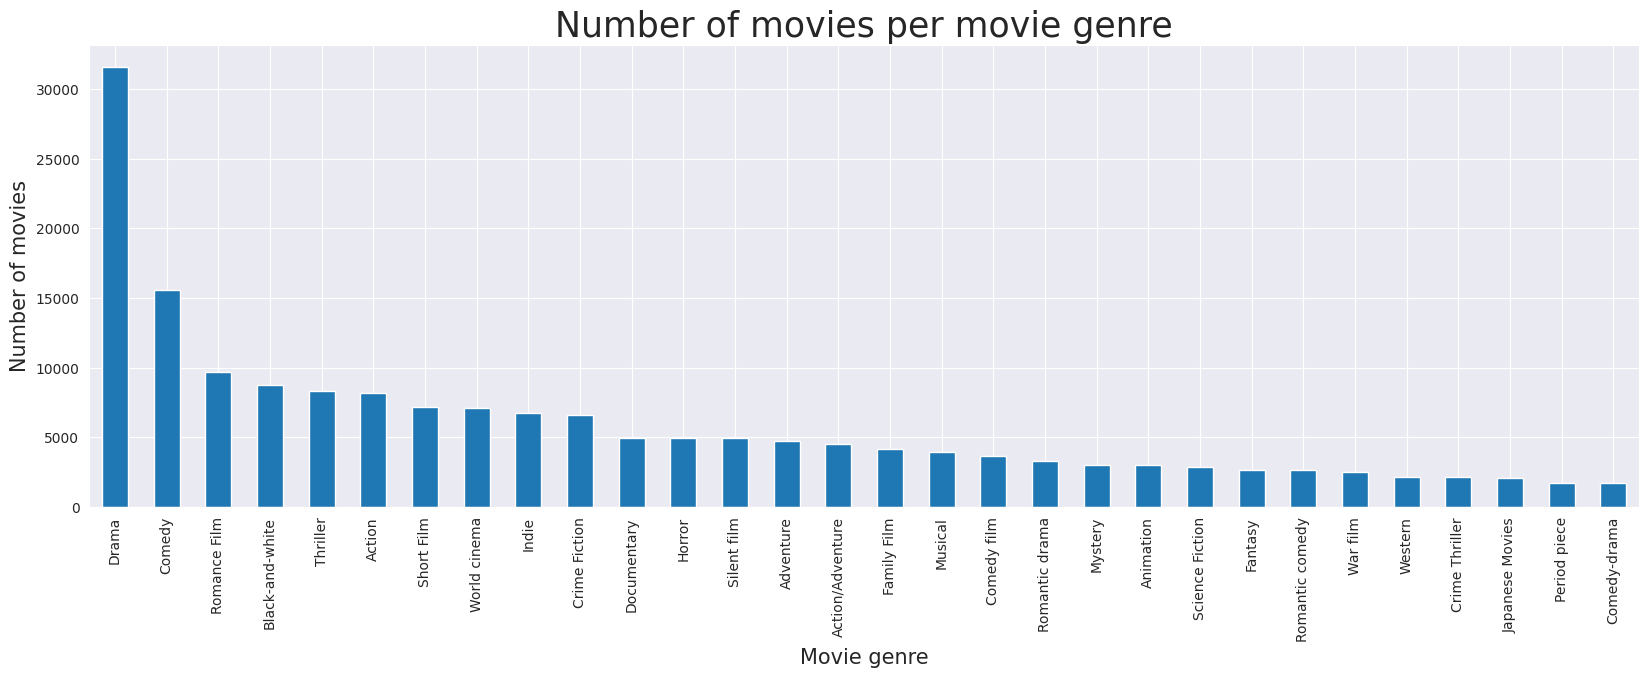

In [27]:
df_genres_m = df_movies.explode('m_genres').dropna(subset='m_genres')
df_genres_m['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

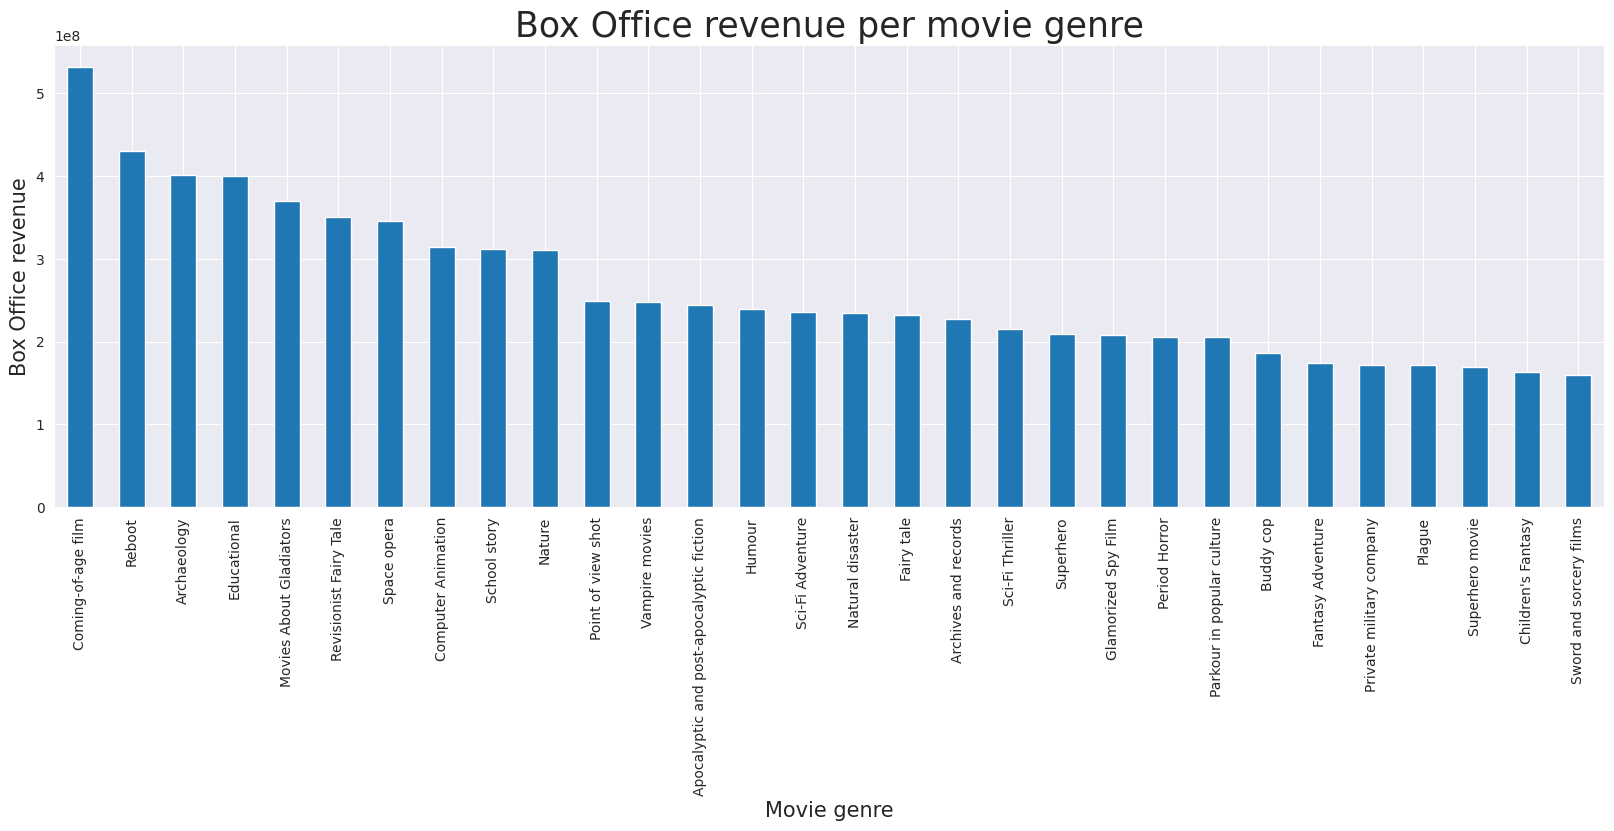

In [28]:
#df_genre_merged_m = df_genres_m.merge(df_movies, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
plt.figure(figsize=(20,6))
df_genres_m[["m_BO_revenue", "m_genres"]].dropna().groupby('m_genres')['m_BO_revenue'].mean().sort_values(ascending=False)[:30].plot(kind='bar')
plt.title('Box Office revenue per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Box Office revenue', fontsize = 15)
plt.show()

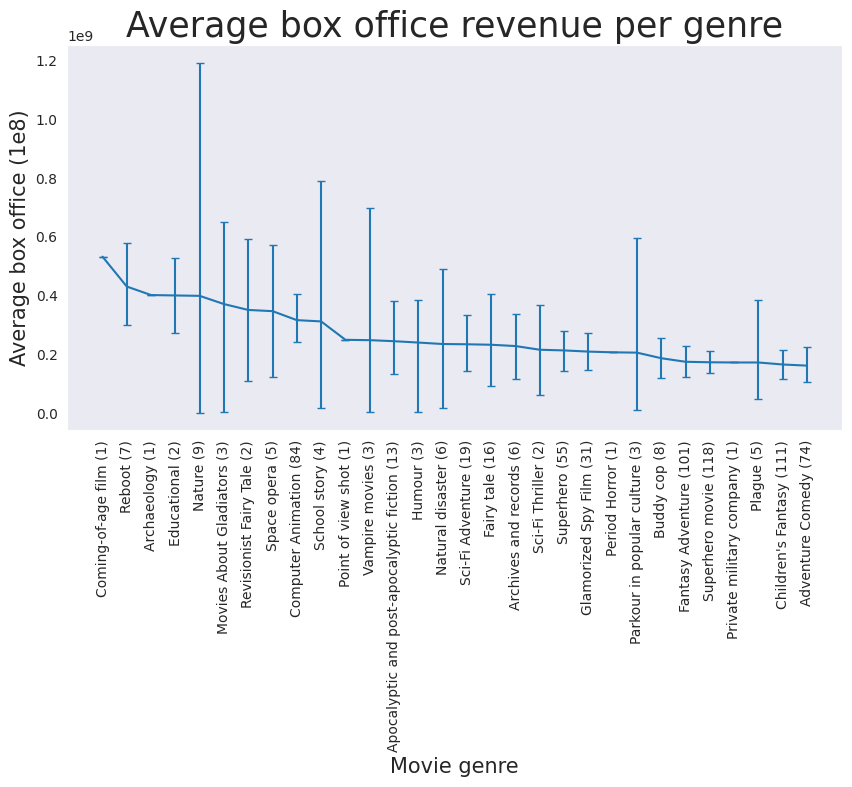

In [29]:
merge = 'm_genres'

stat = df_genres_m.dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(10,5))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_genres_m.dropna(subset='m_BO_revenue')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Movie genre', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e8)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per genre', fontsize=25)
plt.show()

In [30]:
df_genre_a= df_genres_m.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

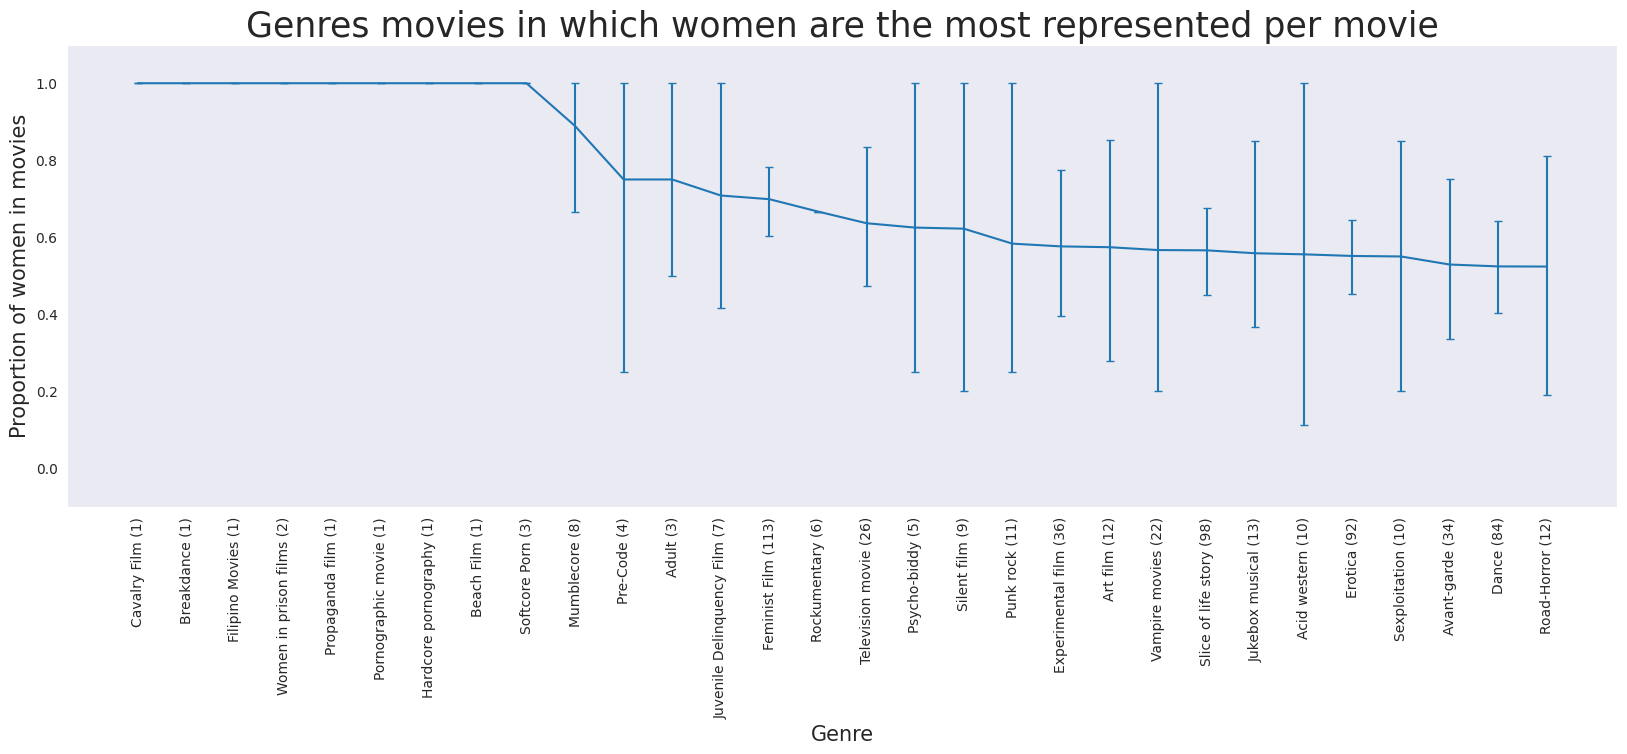

In [31]:
merge = ['m_genres']

df_temp = df_genre_a[['wikipedia_m_ID', 'm_genres', 'actor_gender']].copy()

df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)

stat = df_temp.dropna(subset=['actor_gender', 'm_genres']).groupby(['m_genres', 'wikipedia_m_ID']).mean().groupby(merge).apply(lambda x: pd.Series({
    'average_gender': x['actor_gender'].mean(),
    'lower_err_gender': bootstrap_CI(x['actor_gender'], 1000)[0],
    'upper_err_gender': bootstrap_CI(x['actor_gender'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[:30]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[:30],
         yerr = [-stat.lower_err_gender[:30] + stat.average_gender[:30], 
                -stat.average_gender[:30] + stat.upper_err_gender[:30]],
         capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the most represented per movie', fontsize=25)
plt.show()

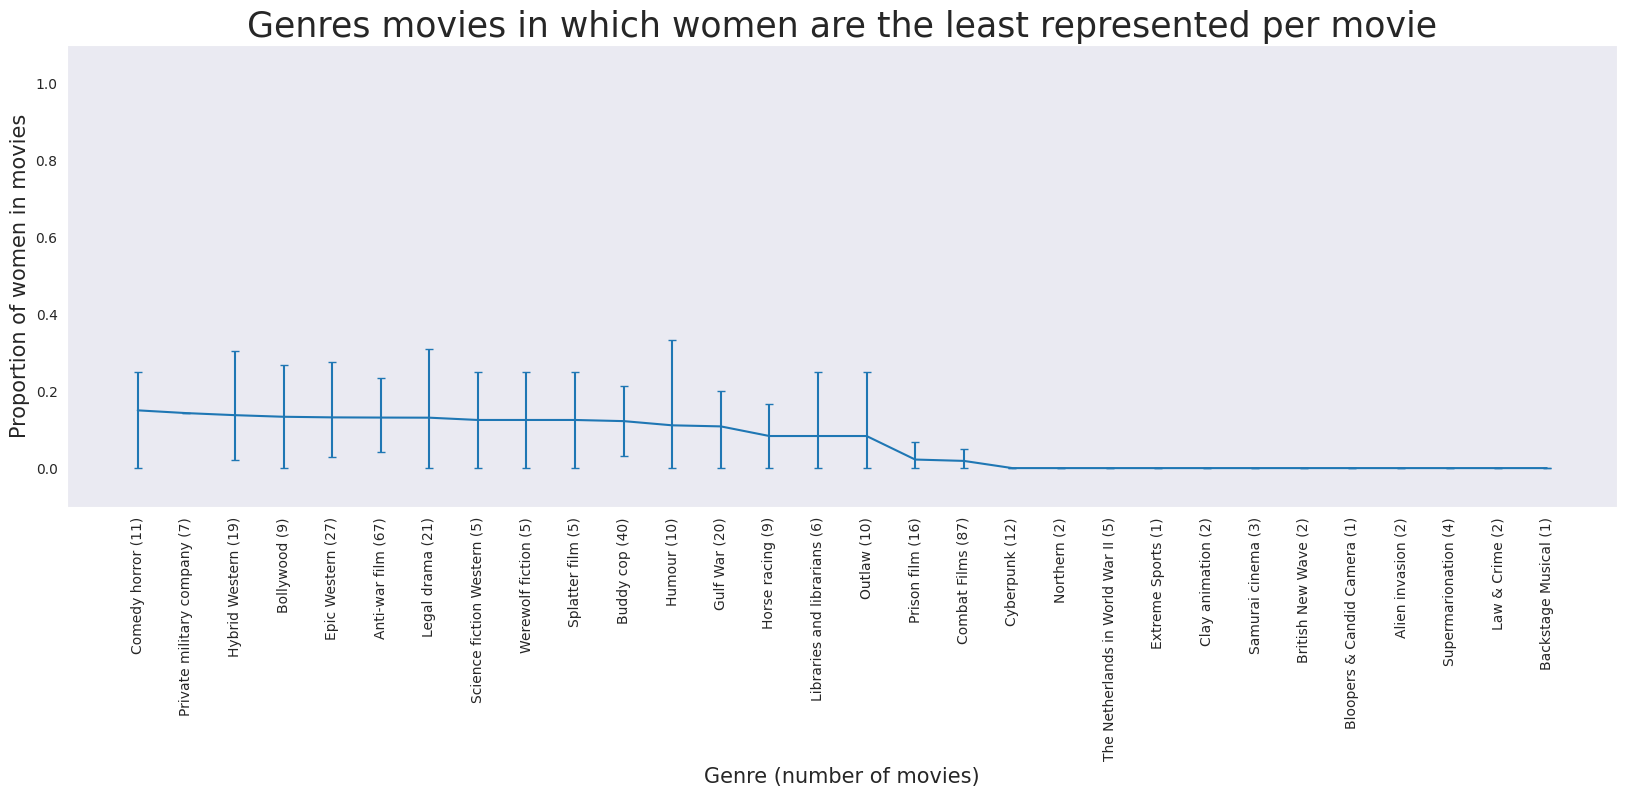

In [32]:
plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[-30:]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[-30:],
         yerr = [-stat.lower_err_gender[-30:] + stat.average_gender[-30:], 
                -stat.average_gender[-30:] + stat.upper_err_gender[-30:]],
         capsize= 3)

plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.xlabel('Genre (number of movies)', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the least represented per movie', fontsize=25)
plt.show()

### Country of production

In [33]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

There are 146 different countries present in the dataset.


Check to know if there were two identical country of production for a same movie.

In [34]:
df_countries_m[df_countries_m.duplicated(['m_countries', 'wikipedia_m_ID'], keep=False)]

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID


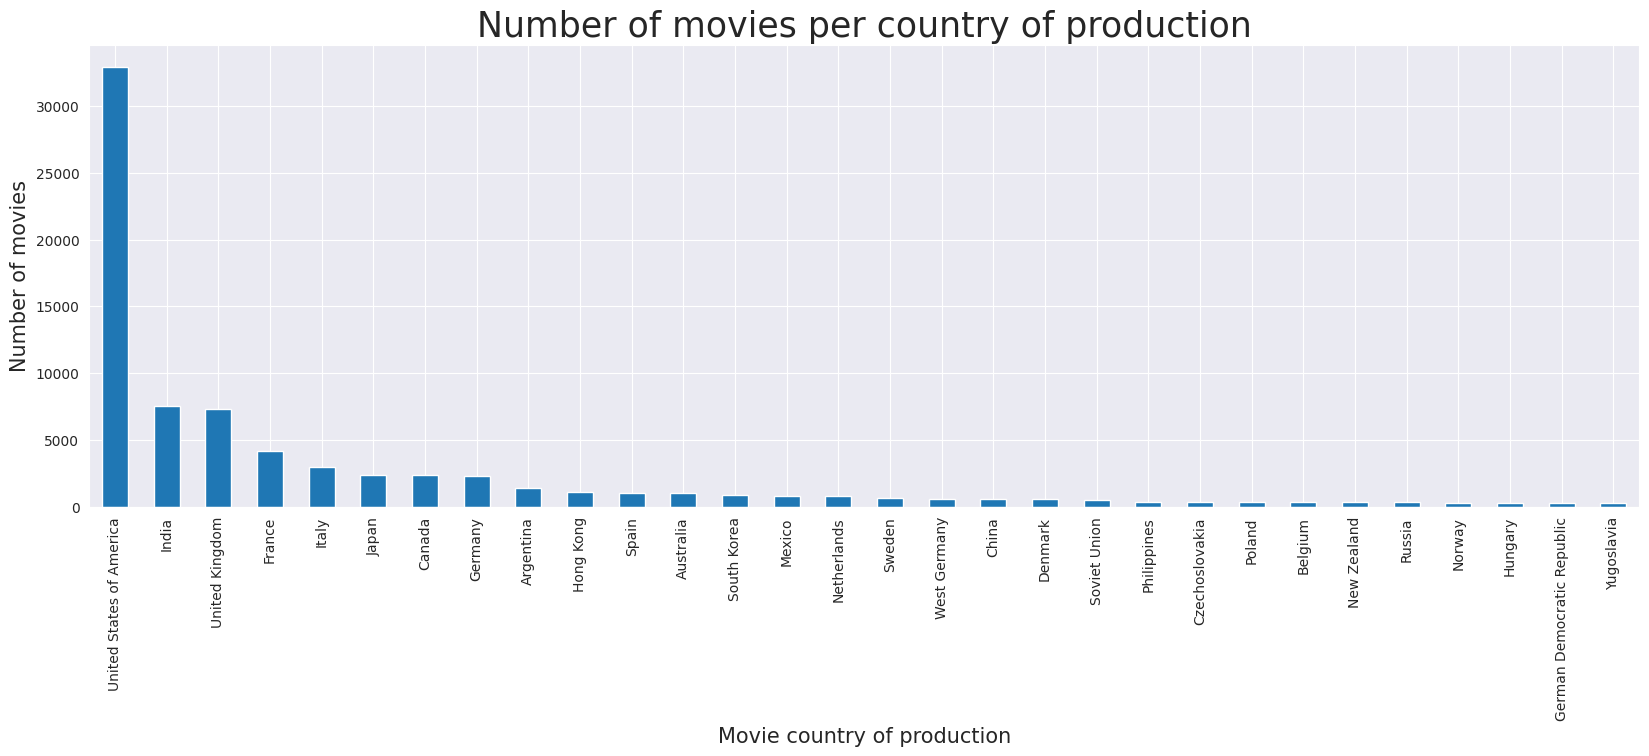

In [35]:
df_countries_m['m_countries'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per country of production', fontsize = 25)
plt.xlabel('Movie country of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [36]:
nb_movies_with_countries = df_countries_m.dropna(subset='m_countries')['wikipedia_m_ID'].nunique()
print("There are {} movies with a known country of production. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_countries, nb_movies_with_countries / nb_movies * 100))

There are 68819 movies with a known country of production. It corresponds to 84.84 % of the movies.


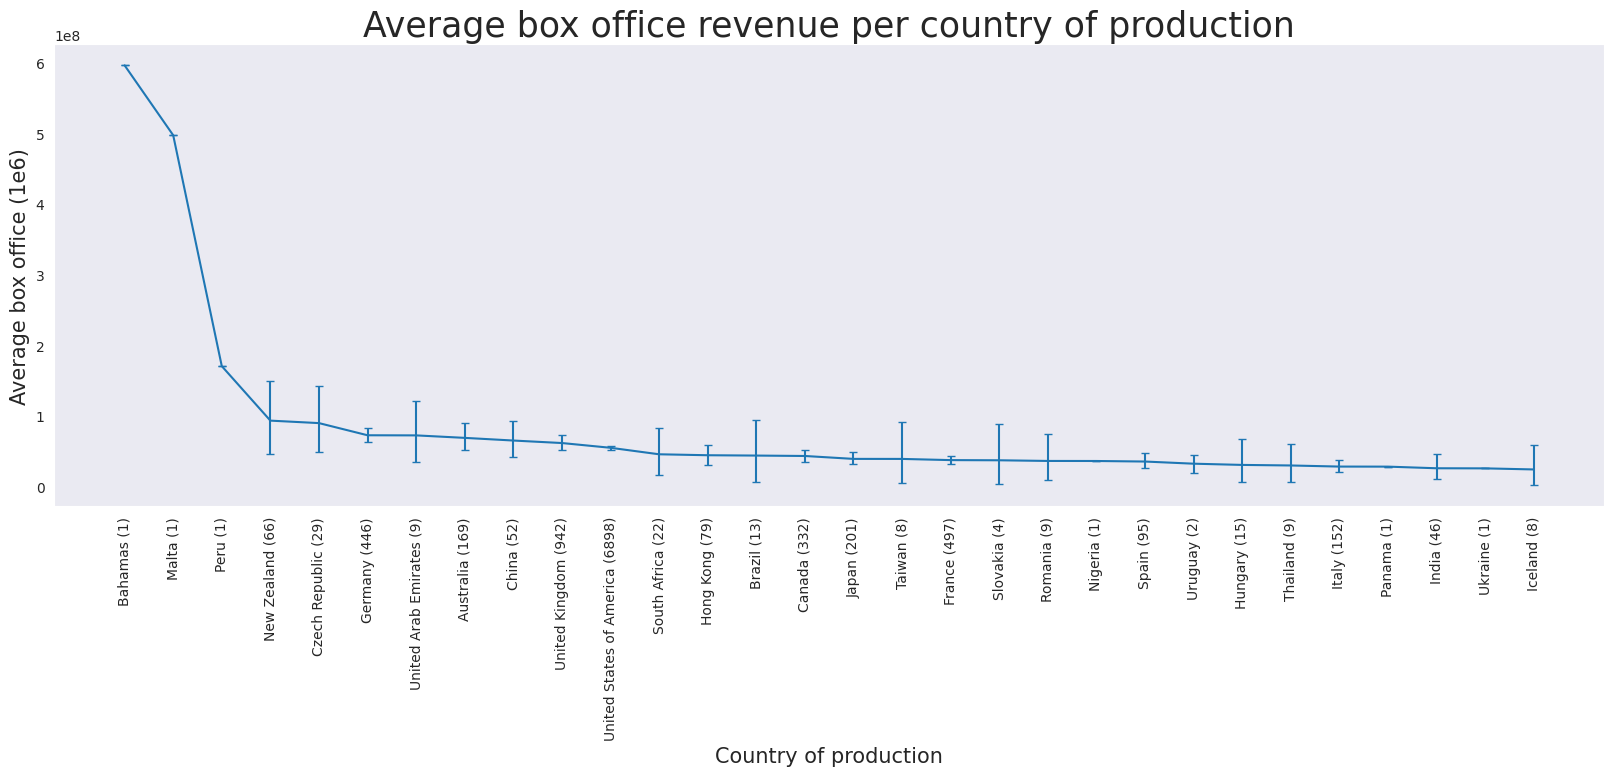

In [37]:
merge = 'm_countries'

stat = df_countries_m.dropna(subset=['m_BO_revenue', 'm_countries']).groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Country of production', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e6)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per country of production', fontsize=25)
plt.show()

In [38]:
nb_value_BO_USA = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()['United States of America']
print("American movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_USA/nb_movies_with_BO *100))

American movies with known box office revenue represent 83.15% of all the movies with a known box office revenue.


### Movie languages

In [39]:
df_languages_m = df_movies.explode('m_languages').dropna(subset='m_languages')
nb_unique_languages = df_languages_m['m_languages'].nunique()
print("There are {} different languages present in the dataset.".format(nb_unique_languages))

There are 204 different languages present in the dataset.


Check to know if there were two identical languages of production for a same movie.

In [40]:
df_languages_m[df_languages_m.duplicated(['m_languages', 'wikipedia_m_ID'], keep=False)]

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID


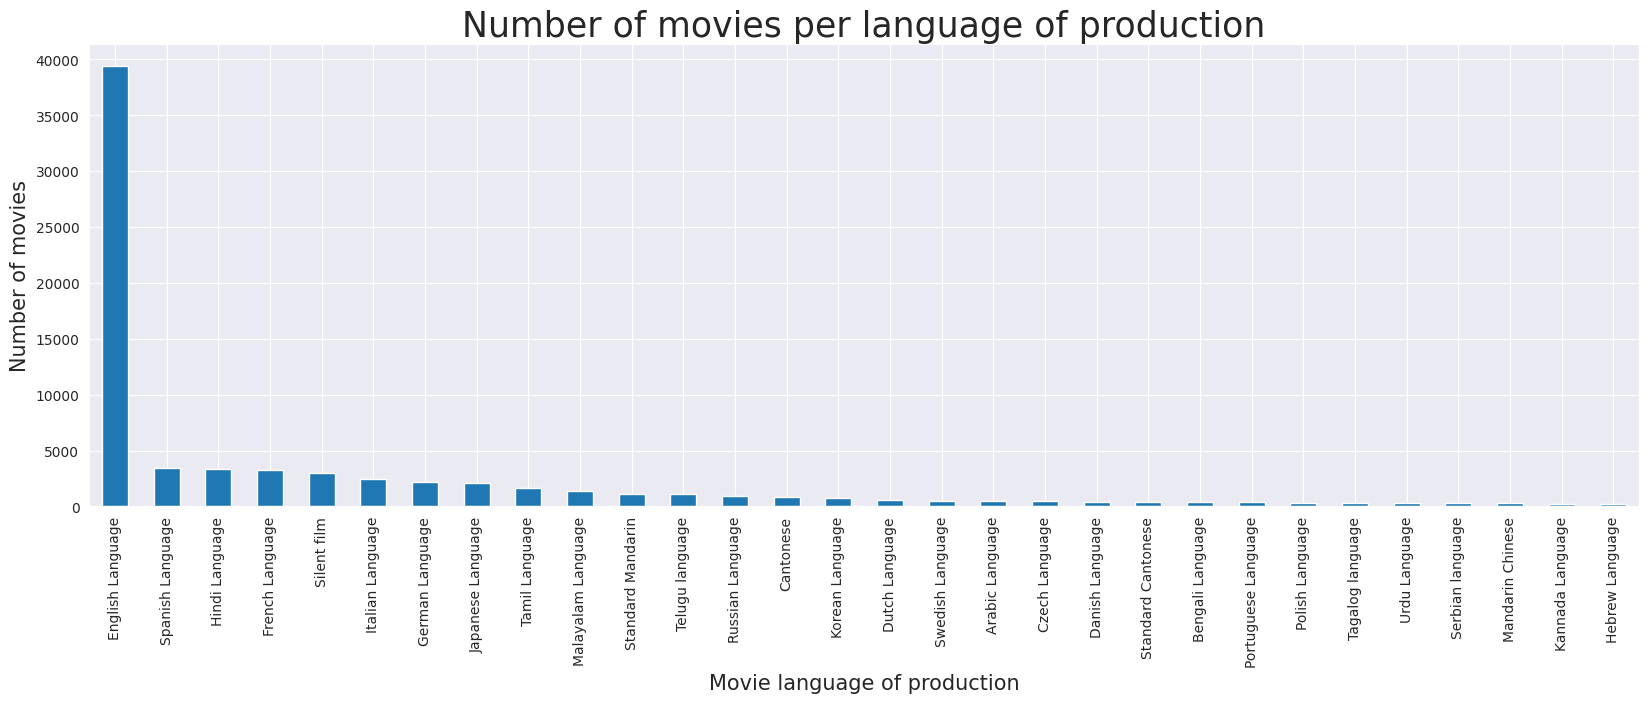

In [41]:
df_languages_m['m_languages'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per language of production', fontsize = 25)
plt.xlabel('Movie language of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [42]:
nb_value_BO_english = df_languages_m.dropna(subset='m_BO_revenue')['m_languages'].value_counts()['English Language']
print("English language movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_english/nb_movies_with_BO *100))

English language movies with known box office revenue represent 88.74% of all the movies with a known box office revenue.


# Zoom on American movies

In [43]:
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']
df_m_a = df_movies_USA.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')

In [44]:
df_movies_USA.describe()

,wikipedia_m_ID,m_BO_revenue,m_runtime
count,3.294100e+04,6.898000e+03,28923.000000
mean,1.349524e+07,5.470920e+07,88.089787
std,1.039122e+07,1.214413e+08,46.731341
min,3.217000e+03,1.047400e+04,0.050000
25%,4.028951e+06,2.400000e+06,77.000000
50%,1.195860e+07,1.300000e+07,91.000000
75%,2.206910e+07,4.979346e+07,102.000000
max,3.750192e+07,2.782275e+09,5220.000000


### Movie genres

In [45]:
df_genres_m_USA = df_movies_USA.explode('m_genres')

In [46]:
nb_genres_USA = df_genres_m_USA['m_genres'].nunique()
print("There are {} different genre in american movies.".format(nb_genres_USA))

There are 341 different genre in american movies.


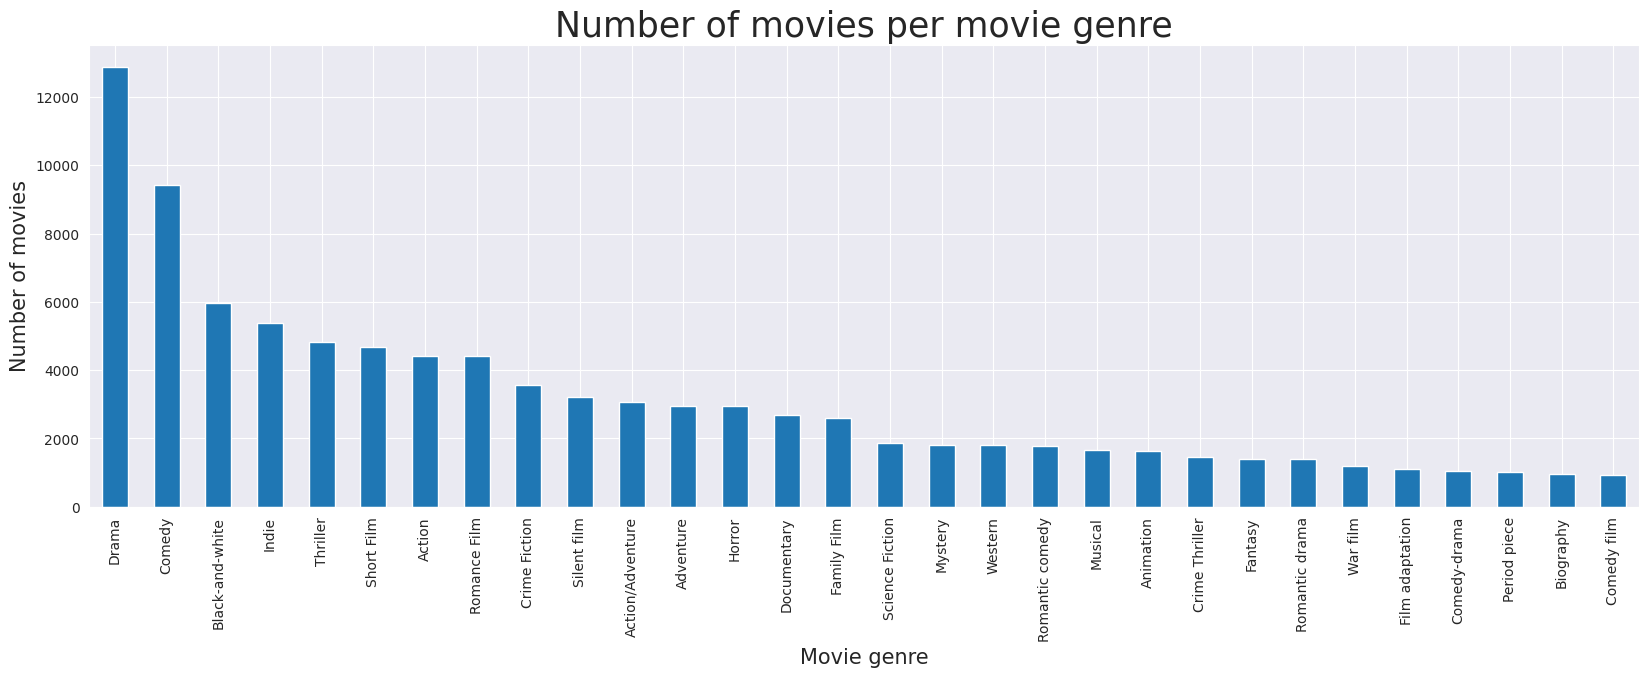

In [47]:
plt.figure(figsize=(20,6))
df_genres_m_USA['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [48]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns

In [49]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

In [50]:
scaler = StandardScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
n=nb_genres_USA
pca = PCA()
pca.fit_transform(df_USA_genres_one_hot)
pca_variance = pca.explained_variance_ratio_
csum = np.cumsum(pca_variance)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


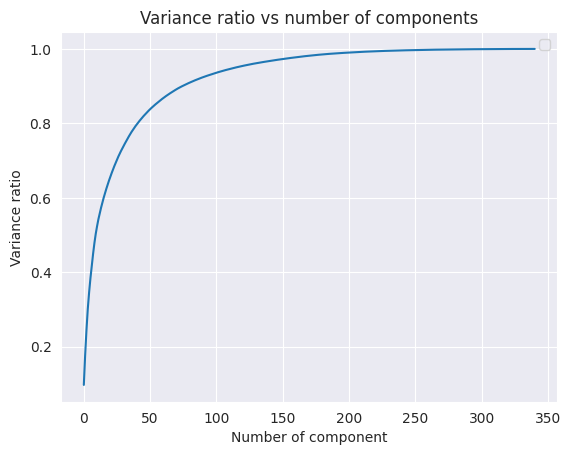

In [51]:
plt.plot(csum)
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Variance ratio vs number of components')
plt.show()

In [52]:
comp = pca.components_

# get the index of the 4 most important features for top 15 components
labels = np.argsort(comp, axis=1)[:15, -4:]

# get the names
top_l = np.empty((15,4), dtype=object)

for i in range(15):
    for j in range(4):
        top_l[i][j] = pca.feature_names_in_[labels[i][j]]

print(top_l)


[['Action' 'Crime Fiction' 'Thriller' 'Drama']
 ['Romance Film' 'Indie' 'Black-and-white' 'Drama']
 ['Romantic drama' 'Romantic comedy' 'Romance Film' 'Comedy']
 ['Action/Adventure' 'Thriller' 'Comedy' 'Action']
 ['Mystery' 'Indie' 'Horror' 'Thriller']
 ['Drama' 'Animation' 'Short Film' 'Family Film']
 ['Horror' 'Romantic comedy' 'Romance Film' 'Black-and-white']
 ['Indie' 'Adventure' 'Science Fiction' 'Horror']
 ['Thriller' 'Animation' 'Short Film' 'Romance Film']
 ['Documentary' 'Indie' 'Crime Fiction' 'Adventure']
 ['Animation' 'Western' 'Horror' 'Crime Fiction']
 ['Action/Adventure' 'Family Film' 'Musical' 'Western']
 ['Documentary' 'Black-and-white' 'Horror' 'Family Film']
 ['Fantasy' 'Action' 'Science Fiction' 'Musical']
 ['Short Film' 'Horror' 'Adventure' 'Musical']]


In [53]:
n_pcs = pca.components_.shape[0]
best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

print(most_important_names[:15])

[['Drama', 'Thriller', 'Crime Fiction', 'Action'], ['Drama', 'Black-and-white', 'Indie', 'Romance Film'], ['Comedy', 'Romance Film', 'Romantic comedy', 'Romantic drama'], ['Action', 'Comedy', 'Thriller', 'Action/Adventure'], ['Thriller', 'Horror', 'Indie', 'Mystery'], ['Family Film', 'Short Film', 'Animation', 'Drama'], ['Black-and-white', 'Romance Film', 'Romantic comedy', 'Horror'], ['Horror', 'Science Fiction', 'Adventure', 'Indie'], ['Romance Film', 'Short Film', 'Animation', 'Thriller'], ['Adventure', 'Crime Fiction', 'Indie', 'Documentary'], ['Crime Fiction', 'Horror', 'Western', 'Animation'], ['Western', 'Musical', 'Family Film', 'Action/Adventure'], ['Family Film', 'Horror', 'Black-and-white', 'Documentary'], ['Musical', 'Science Fiction', 'Action', 'Fantasy'], ['Musical', 'Adventure', 'Horror', 'Short Film']]


### Actor representation

In [54]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [55]:
df_m_a.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,...,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## visu of movie genres and interaction

 for a time span (10 years ?) graph of :
* each category ?
* overall graph ?
* compute interesting graph properties


## evolution of genre. "cumulative bar plots" ?
 take actors born at the same period ? or actors that have high vs low popularity ?
 how to represent data ?

In [56]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()


pca = PCA(n_components=15)
new_space = pca.fit_transform(df_USA_genres_one_hot)
new_space = new_space.argmax(axis=1)
df_USA_genres_one_hot['m_genre_PCA'] = new_space
df_USA_genres_one_hot['m_genre_PCA'] = df_USA_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

temp_df = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID').drop(columns=['m_BO_revenue', 'm_runtime', 'm_languages', 'm_countries', 'm_genres', 'm_languages_freebase_ID', 'm_countries_freebase_ID', 'm_genres_freebase_ID'])


In [57]:
big_df = pd.merge(temp_df, df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')
big_df = big_df.drop(columns=['freebase_m_ID', 'wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_age', 'freebase_character_id', 'freebase_character_map', 'freebase_actor_id'])

big_df

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,character_name,actor_name
0,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Akooshay,Wanda De Jesus
1,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Lieutenant Melanie Ballard,Natasha Henstridge
2,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Desolation Williams,Ice Cube
3,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Sgt Jericho Butler,Jason Statham
4,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Bashira Kincaid,Clea DuVall
...,...,...,...,...,...,...
166102,24209227,"The Time, the Place and the Girl",1946-01-01,"Musical, Science Fiction, Action, Fantasy",NaN,Angela Greene
166103,24209227,"The Time, the Place and the Girl",1946-01-01,"Musical, Science Fiction, Action, Fantasy",NaN,Dennis Morgan
166104,24209227,"The Time, the Place and the Girl",1946-01-01,"Musical, Science Fiction, Action, Fantasy",NaN,Janis Paige
166105,9971909,Another Nice Mess,1972-09-22,"Comedy, Romance Film, Romantic comedy, Romanti...",NaN,Rich Little


In [58]:
action_actors = big_df
genre_dict = {}
for vec in action_actors.m_genre_PCA.drop_duplicates():
    genre_dict[vec] = action_actors[action_actors['m_genre_PCA'] == vec]

test_graph = genre_dict['Horror, Science Fiction, Adventure, Indie']

graph = pd.merge(test_graph, test_graph, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
test_graph

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,character_name,actor_name
0,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Akooshay,Wanda De Jesus
1,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Lieutenant Melanie Ballard,Natasha Henstridge
2,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Desolation Williams,Ice Cube
3,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Sgt Jericho Butler,Jason Statham
4,975900,Ghosts of Mars,2001-08-24,"Horror, Science Fiction, Adventure, Indie",Bashira Kincaid,Clea DuVall
...,...,...,...,...,...,...
166066,7761830,Spaced Invaders,1990-01-01,"Horror, Science Fiction, Adventure, Indie",NaN,Douglas Barr
166067,7761830,Spaced Invaders,1990-01-01,"Horror, Science Fiction, Adventure, Indie",NaN,Gregg Berger
166068,7761830,Spaced Invaders,1990-01-01,"Horror, Science Fiction, Adventure, Indie",NaN,Tonya Lee Williams
166069,7761830,Spaced Invaders,1990-01-01,"Horror, Science Fiction, Adventure, Indie",NaN,Fred Applegate


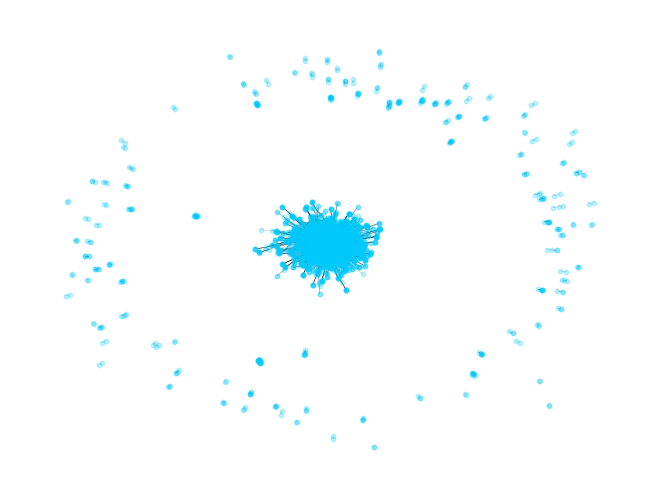

In [59]:
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')

nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)


As we can see, not all actors in this category are connected, let's see how the GCC looks like

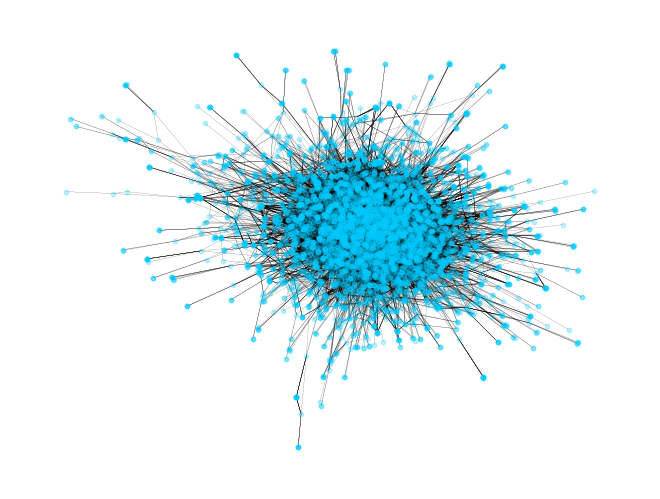

In [60]:
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)

<AxesSubplot: ylabel='Count'>

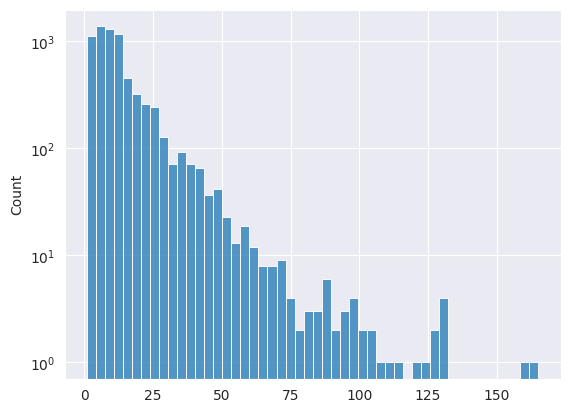

In [61]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
sns.histplot(degree_sequence, bins=50, log=True)

Text(0.5, 1.0, 'Node degree distribution')

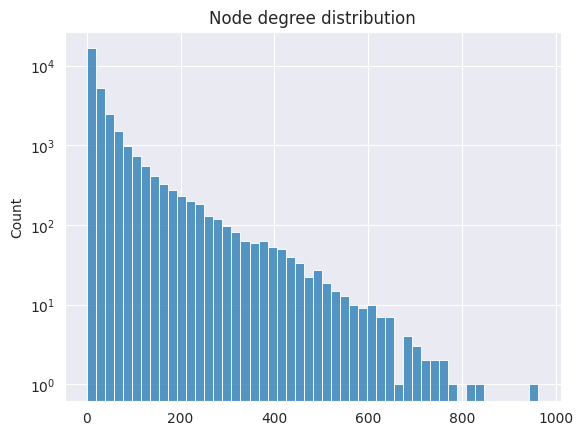

In [62]:
t_graph = pd.merge(big_df, big_df, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
t_graph = t_graph[t_graph.actor_name_x < t_graph.actor_name_y]

G = nx.from_pandas_edgelist(t_graph, 'actor_name_x', 'actor_name_y')
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
sns.histplot(degree_sequence, bins=50, log=True)
plt.title("Node degree distribution")

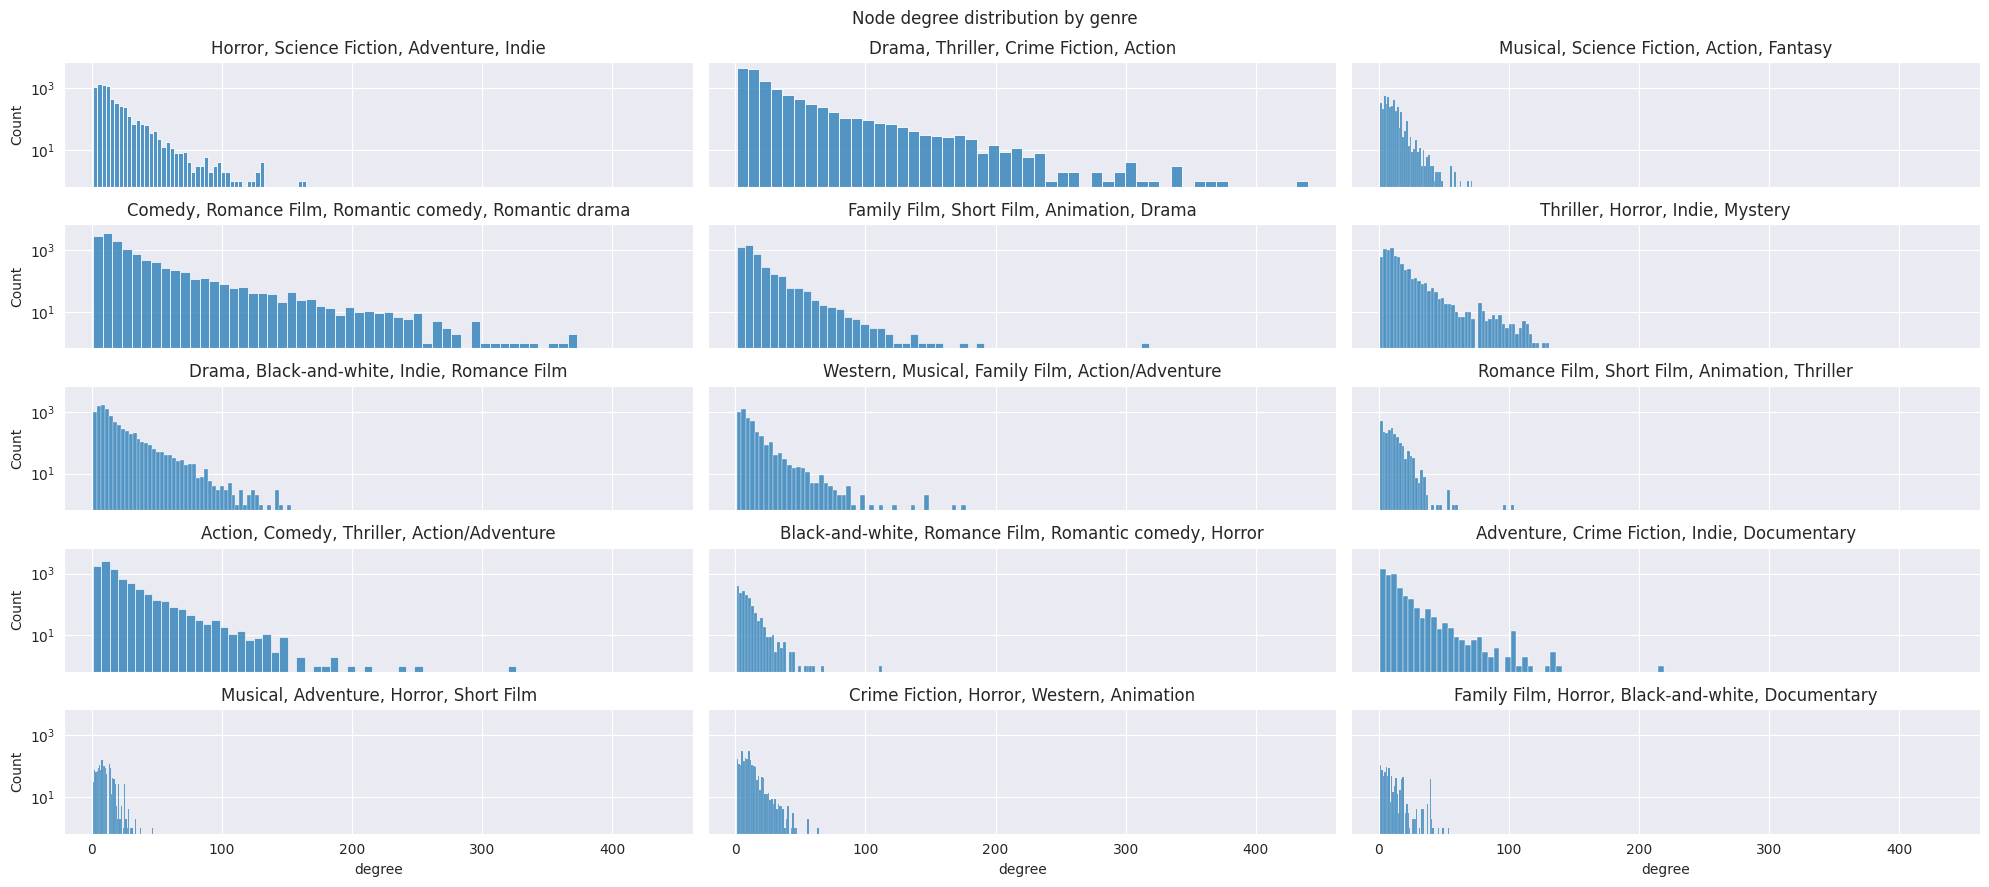

In [63]:
fig, axs = plt.subplots(5, 3, figsize=(20, 9), sharey='all', sharex='all')

i = 0
for k in genre_dict:
    ax= axs[int(i/3)][i%3]
    graph = pd.merge(genre_dict[k], genre_dict[k], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
    graph = graph[graph.actor_name_x < graph.actor_name_y]
    g = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')

    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    sns.histplot(degree_sequence, bins=50, log=True, ax=ax)
    ax.set_title(k)
    ax.set_xlabel("degree")
    i+=1
plt.suptitle("Node degree distribution by genre")
plt.tight_layout()
plt.show()

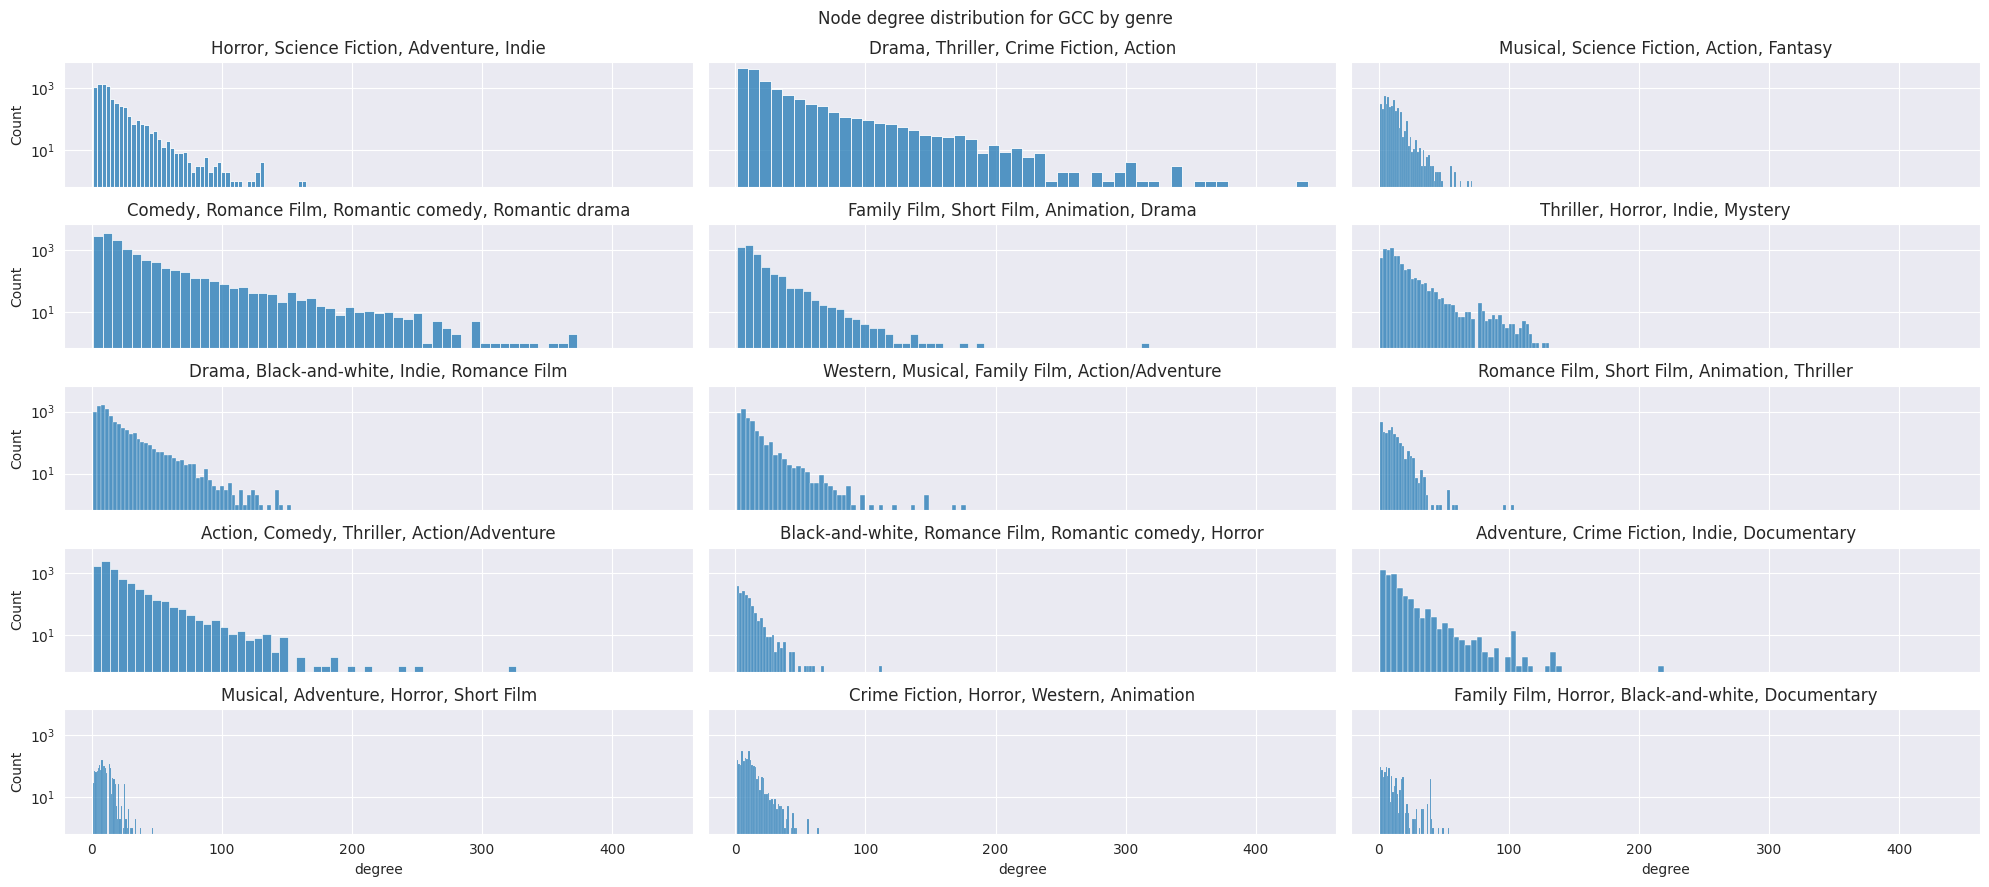

In [64]:
fig, axs = plt.subplots(5, 3, figsize=(20, 9), sharey='all', sharex='all')

i = 0
for k in genre_dict:
    ax= axs[int(i/3)][i%3]
    graph = pd.merge(genre_dict[k], genre_dict[k], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
    graph = graph[graph.actor_name_x < graph.actor_name_y]
    g = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
    largest_cc = max(nx.connected_components(G), key=len)
    gcc = g.subgraph(largest_cc)

    degree_sequence = sorted((d for n, d in gcc.degree()), reverse=True)
    sns.histplot(degree_sequence, bins=50, log=True, ax=ax)
    ax.set_title(k)
    ax.set_xlabel("degree")
    i+=1
plt.suptitle("Node degree distribution for GCC by genre")
plt.tight_layout()
plt.show()

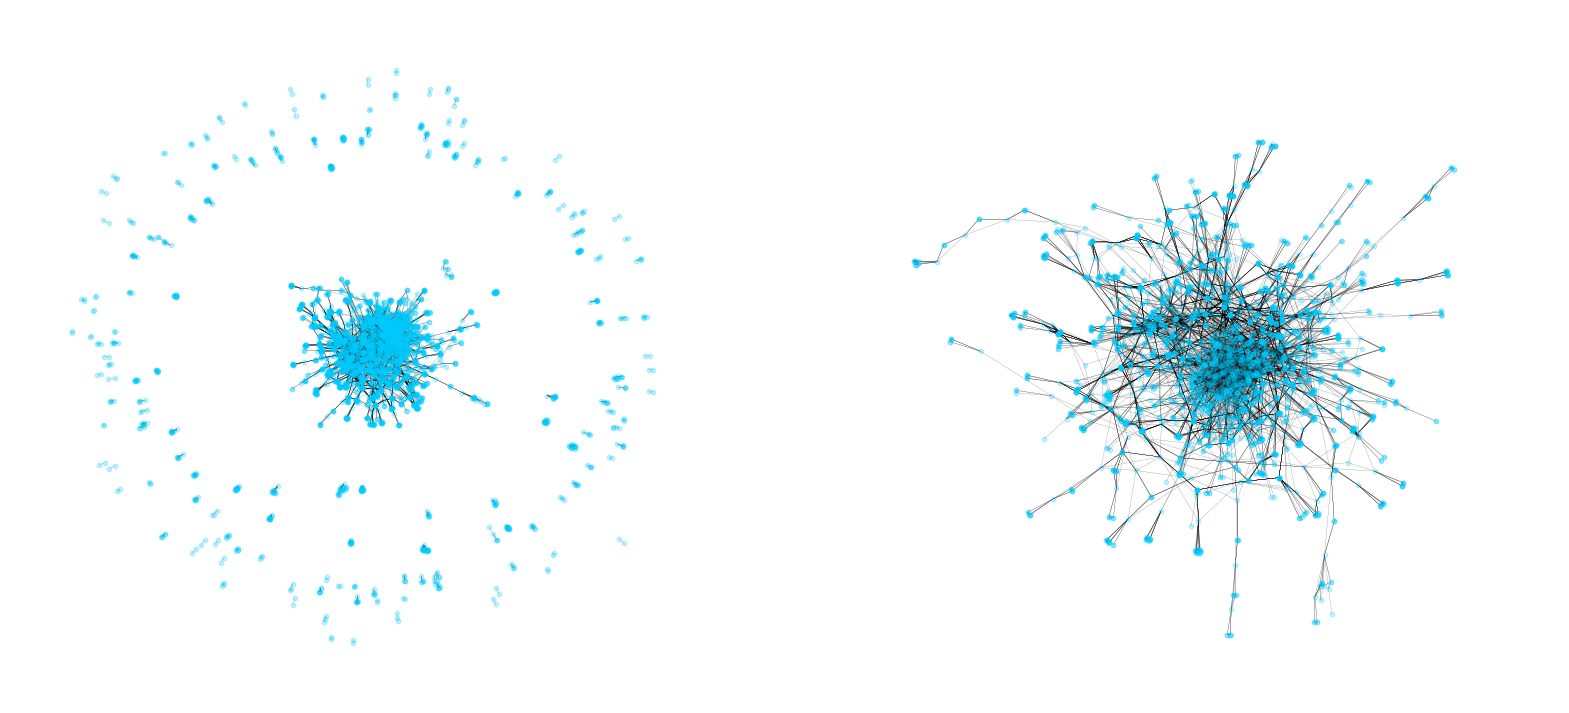

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9), sharey='all', sharex='all')

graph = pd.merge(genre_dict['Musical, Science Fiction, Action, Fantasy'], genre_dict['Musical, Science Fiction, Action, Fantasy'], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[0])
nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[1])

We can see that all genre follow the same distribution, but with different parameters. We can see that the connectivity of a

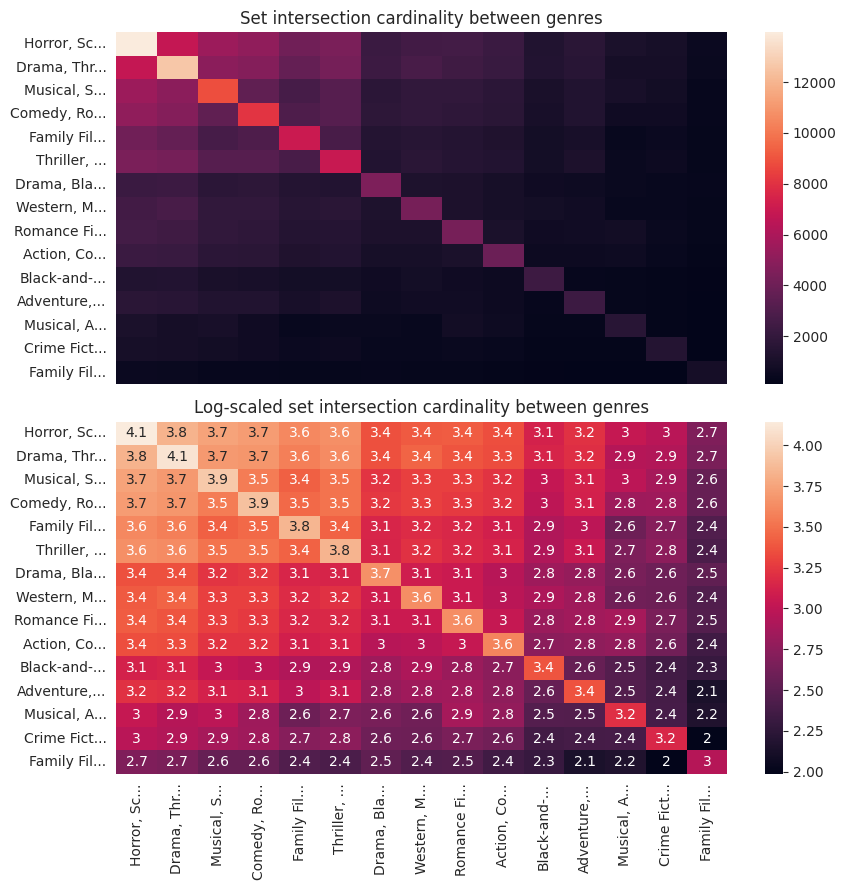

In [210]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9), sharex='all')

intersection_log = np.empty((15, 15))
intersection = np.empty((15, 15))
actors = []
heatmap_labels = []

for k in genre_dict:
    actor_set = set(genre_dict[k]['actor_name'])
    actors.append([k, len(actor_set), actor_set])
    heatmap_labels.append(k[:10]+"...")

actors.sort(key=lambda x: x[1], reverse=True)

i =0
for genre1 in actors:
    j=0
    for genre2 in actors:
        intersection[i][j] = len(genre1[2].intersection(genre2[2]))
        j+=1
    i+=1

intersection_log = np.log10(intersection)

sns.heatmap(intersection, ax=axs[0],  yticklabels=heatmap_labels)
sns.heatmap(intersection_log, annot=True, ax=axs[1], xticklabels=heatmap_labels, yticklabels=heatmap_labels)

axs[0].set_title('Set intersection cardinality between genres')
axs[1].set_title('Log-scaled set intersection cardinality between genres')
plt.tight_layout()
plt.show()

In [200]:
# find distribution for 1st film, second film, ... per actor
test = big_df.sort_values(['actor_name', 'm_release_date']).reset_index()[['m_genre_PCA', 'actor_name']]
test['number'] = 0
test.dropna(subset='actor_name', axis=0, inplace=True)
prev_actor = ""
i = 0
test = test[test.actor_name != 'Mel Blanc']
for idx, row in test.iterrows():
    if row.actor_name != prev_actor:
        prev_actor = row.actor_name
        i = 0
    i+=1
    test.at[idx, 'number'] = i

In [199]:
stacked_df = pd.DataFrame()
for group in test.groupby('m_genre_PCA'):
    tmp = group[1].groupby('number').count()['actor_name']
    tmp = tmp.reindex(list(range(1,tmp.index.max()+1)), fill_value=0)
    stacked_df[group[0]] = tmp

stacked_df = stacked_df.fillna(0)

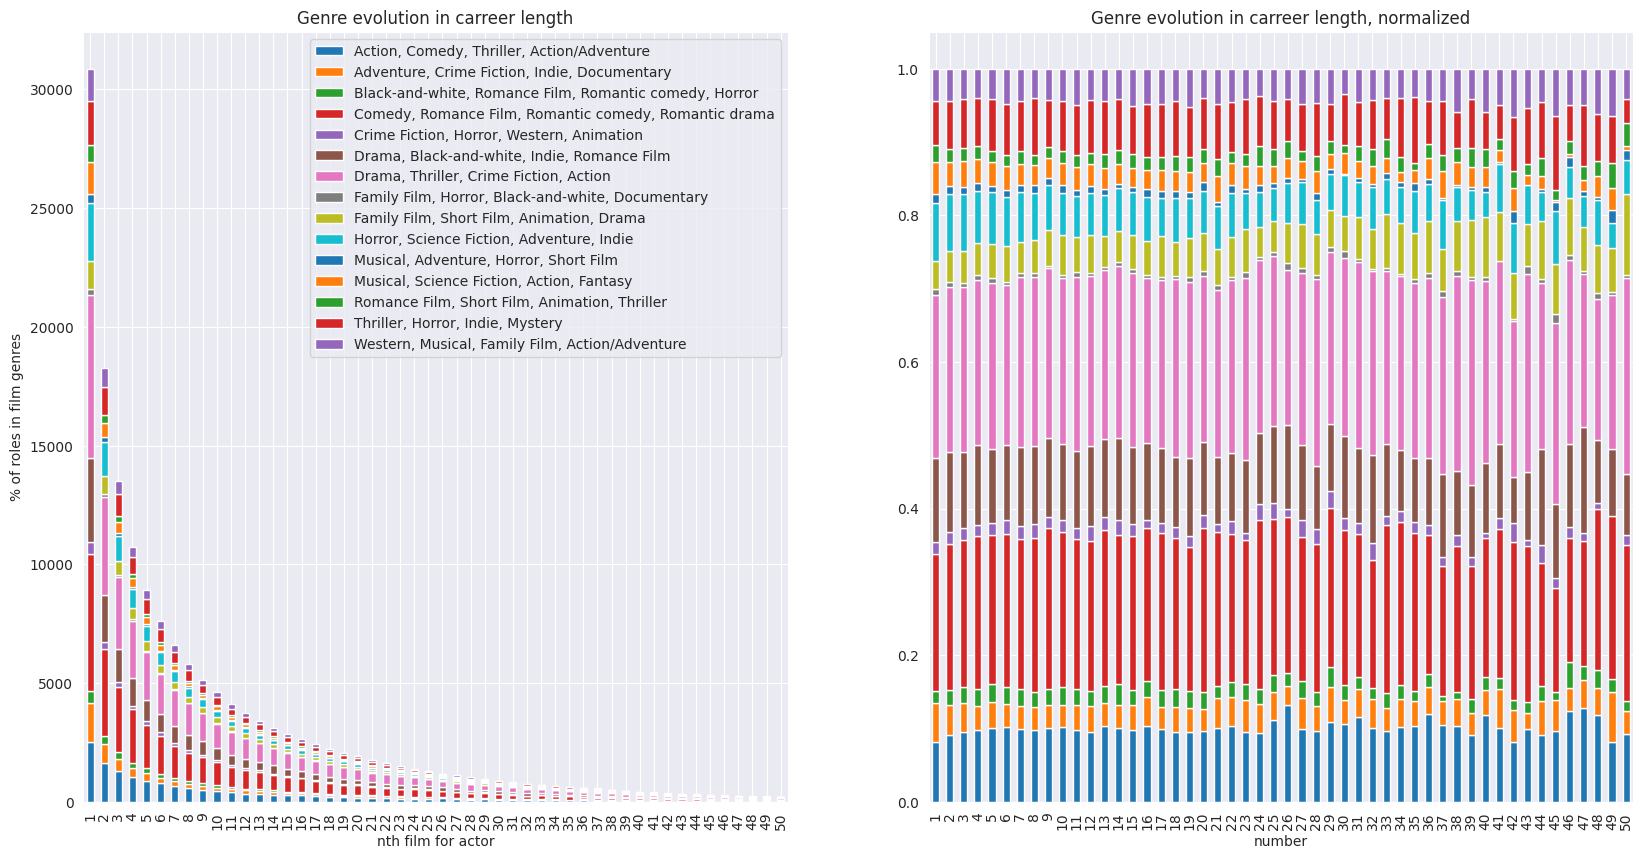

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
stacked_df.head(50).plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Genre evolution in carreer length')
axs[0].set_xlabel('nth film for actor')
axs[0].set_ylabel('count of roles in film genres')
norm_stacked = stacked_df.copy()
norm_stacked = norm_stacked.apply(lambda row: row/row.sum(), axis=1)

norm_stacked.head(50).plot(kind='bar', stacked=True, ax=axs[1], legend=False)
axs[1].set_title('Genre evolution in carreer length, normalized')
axs[0].set_xlabel('nth film for actor')
axs[0].set_ylabel('% of roles in film genres')

plt.show()